In [203]:
import os

os.chdir('/opt/ml/P-Stage/1-STAGE/')

In [2]:
""" 모델의 다양한 성능을 측정  """

import os
from PIL import Image

import wandb
import torch
import numpy as np
import pandas as pd
import torch.nn as nn

import matplotlib.pyplot as plt

from train import evaluate, get_lossfn
from config import get_args
from prepare import get_dataloader, get_transforms
from metrics import (
    change_2d_to_1d,
    change_age_to_cat,
    cal_metrics,
    cal_accuracy,
    FocalLoss,
)


def eval_class(mi, gi, ai):
    return 6 * mi + 3 * gi + ai


def _log_f1_and_acc_scores(args, summary_table, labels, outputs):
    args.train_key = key
    _, labels, outputs = evaluate(args, model, loss_fn, data_loader)

    # class 별 f1_score를 계산해야함.

    f1_score = cal_metrics(outputs, labels)
    acc_score = cal_accuracy(outputs, labels)

    summary_table.loc[key] = [f1_score, acc_score]

    return labels, outputs

def _log_confusion_matrix(args, labels, outputs):
    return 

def _log_():
    return


def log_scores(args, keys, models):
    """ loss_fn: use same model """

    label_list, output_list = [], []
    loss_fn = get_lossfn(args).to(args.device)

    summary_table = pd.DataFrame(columns=["f1_score", "accuracy"])

    for model, key in zip(models, keys):
        args.train_key = key
        _, valid_dataloader = get_dataloader(args)
        
        labels, outputs = evaluate(args, model, loss_fn, valid_dataloader)

        _log_f1_and_acc_scores(args, summary_table, labels, outputs)
        _log_confusion_matrix(args, labels, outputs)


        label_list.append(labels.detach().cpu().numpy())
        output_list.append(outputs.detach().cpu().numpy())

    return summary_table, label_list, output_list


def load_models(args):
    try:
        age_model = torch.load(args.age_model).to(args.device)
        gender_model = torch.load(args.gender_model).to(args.device)
        mask_model = torch.load(args.mask_model).to(args.device)

        age_model.eval()
        gender_model.eval()
        mask_model.eval()
    except Exception as e:
        raise e
    
    return [mask_model, gender_model, age_model]  # 순서 중요


def main(args):
    wandb.init(project="p-stage-1", reinit=True)
    wandb.config.update(args)
    wandb.run.name = f"predict-{wandb.run.name}"

    print("".join([f"{k:<15} : {v}\n" for k, v in sorted(wandb.config.items(), key=len)]))

    models = load_models(args)
    keys = ["mask", "gender", "age"]

    # mga: mask, gender, age (sequence)
    summary_table, mga_label_lists, mga_output_lists = log_scores(
        args, summary_table, keys, models
    )

    labels, outputs = [], []

    for (mi, gi, ai) in zip(*mga_label_lists):
        labels.append(eval_class(mi, gi, ai))

    for (mi, gi, ai) in zip(*mga_output_lists):
        outputs.append(eval_class(mi, gi, ai))

    acc = cal_accuracy(torch.tensor(labels), torch.tensor(outputs))
    table = wandb.Table(dataframe=summary_table, rows=keys)

    wandb.log({"Result": table, "valid_accuracy": acc})

In [3]:
args = get_args()
args.device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [40]:
models = load_models(args)
keys = ['mask', 'gender', 'age']

In [162]:
args.test = False
args.train_key = "mask"

loss_fn = get_lossfn(args)
_, dataloader = get_dataloader(args)
_, labels, outputs = evaluate(args, models[0], loss_fn, dataloader)

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1529: DeprecationWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn("This class has been deprecated. Please use CoarseDropout", DeprecationWarning)


In [163]:
labels, outputs = labels.detach().cpu().numpy().astype(np.int), outputs.detach().cpu().numpy().astype(np.int)

In [7]:
class_index = np.where(labels == 2)

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [25]:
accuracy_score(labels[class_index], outputs[class_index])

0.5333333333333333

In [26]:
f1_score(labels[class_index], outputs[class_index], average='macro')

0.3478260869565218

In [27]:
precision_score(labels[class_index], outputs[class_index], average='macro')

0.5

In [28]:
recall_score(labels[class_index], outputs[class_index], average='macro')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.26666666666666666

In [12]:
labels[class_index], outputs[class_index]

(array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       dtype=float32),
 array([0., 2., 2., 0., 2., 2., 2., 0., 0., 2., 2., 0., 0., 0., 2.],
       dtype=float32))

In [15]:
labels, outputs

(array([0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0.,
        0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
        0., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2.,
        0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1.,
        0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
        2., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 2., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
        0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
        0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       dtype=float32))

## PipeLine

In [51]:
from prepare import get_classes

import warnings
warnings.filterwarnings('always')

In [152]:
summary_table = pd.DataFrame([])

In [153]:
for model, key in zip(models, keys):
    args.train_key = key
    _, dataloader = get_dataloader(args)
    _, labels, outputs = evaluate(args, model, loss_fn, dataloader)
    labels, outputs = labels.detach().cpu().numpy(), outputs.detach().cpu().numpy()
    classes = get_classes(args.train_key)
    
    summary_table.loc[key, "all_f1"] = 
    sum
    
    for class_idx in range(len(classes)):
        fancy_idx = np.where(labels == class_idx)
        f1 = f1_score(labels[fancy_idx], outputs[fancy_idx], average='macro')
        pr = precision_score(labels[fancy_idx], outputs[fancy_idx], average='macro')
        re = recall_score(labels[fancy_idx], outputs[fancy_idx], average='macro')
        acc = accuracy_score(labels[fancy_idx], outputs[fancy_idx])
        
        summary_table.loc[key, f"{class_idx} f1"] = f1
        summary_table.loc[key, f"{class_idx} pr"] = pr
        summary_table.loc[key, f"{class_idx} re"] = re
        summary_table.loc[key, f"{class_idx} acc"] = acc

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1529: DeprecationWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn("This class has been deprecated. Please use CoarseDropout", DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1529: DeprecationWarning: This class has been deprecated. Please use CoarseDr

In [154]:
summary_table

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,1.00,1.00,1.00,1.00,0.07,0.50,0.04,0.07,0.35,0.50,0.27,0.53
gender,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,nan,nan,nan,nan
age,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [136]:
s_table = summary_table.fillna(0)

In [155]:
summary_table = summary_table.fillna(0)
summary_table = summary_table.applymap(lambda x: "{:,.2f}%".format(x*100))
s_table = summary_table.style.background_gradient(cmap=cm)

In [156]:
s_table

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,100.00%,100.00%,100.00%,100.00%,6.67%,50.00%,3.57%,7.14%,34.78%,50.00%,26.67%,53.33%
gender,0.00%,0.00%,0.00%,0.00%,100.00%,100.00%,100.00%,100.00%,0.00%,0.00%,0.00%,0.00%
age,100.00%,100.00%,100.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [142]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)
s_table = s_table.style.format("{:,.2%}")
s_table = summary_table.style.background_gradient(cmap=cm)
s_table

AttributeError: 'Styler' object has no attribute 'style'

In [138]:
s_table

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,100.00%,100.00%,100.00%,100.00%,6.67%,50.00%,3.57%,7.14%,34.78%,50.00%,26.67%,53.33%
gender,0.00%,0.00%,0.00%,0.00%,100.00%,100.00%,100.00%,100.00%,0.00%,0.00%,0.00%,0.00%
age,100.00%,100.00%,100.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [121]:
s = summary_table.applymap(lambda x: "{:,.2f}".format(x))
s

,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,1.000000,1.000000,1.000000,1.000000,0.066667,0.500000,0.035714,0.071429,0.347826,0.500000,0.266667,0.533333
gender,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
age,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [122]:
s.style.format("{:.2%}")

AttributeError: 'Styler' object has no attribute 'style'

In [229]:
labels, outputs.shape

(array([0, 2, 0, ..., 1, 0, 0]), (9450,))

## Confusion Matrix

In [158]:
from sklearn.metrics import confusion_matrix

In [204]:
cf_m = confusion_matrix(labels, outputs)
cf_m

array([[6638,   25,   87],
       [1282,   31,   37],
       [ 744,   10,  596]])

In [210]:
sample_classes = get_classes(args.train_key)
sample_classes

['wear', 'incorrect', 'not wear']

In [ ]:
ax.set_xtick

In [240]:
def plot_confusion_matrix(matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)
    matrix = matrix / row_sums
    np.fill_diagonal(matrix, 0)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap=plt.cm.gray)
    ax.set_title("GD")
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_xticklabels(sample_classes)
    ax.set_yticklabels(sample_classes)

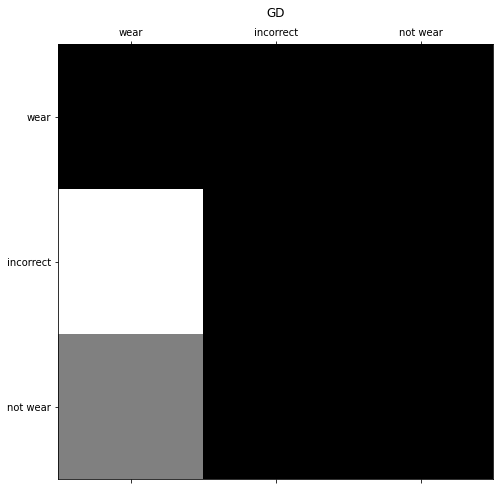

In [241]:
plot_confusion_matrix(cf_m)

In [353]:
args.test = True

images, labels = next(iter(dataloader))
outputs = models[0](images.cuda())

images = images.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()
outputs = outputs.detach().cpu().numpy()
images.shape, labels.shape, outputs.shape

((64, 3, 224, 224), (64,), (64, 3))

In [260]:
classes

['age < 30', '30 <= age < 60', '60 <= age']

In [357]:
outputs = np.argmax(outputs, 1)
outputs

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [358]:
labels

array([0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2,
       0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0])

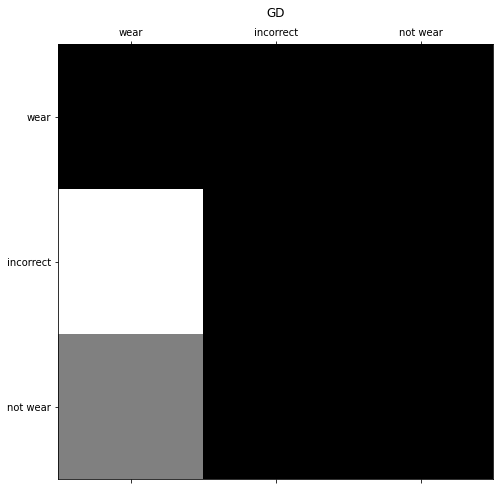

In [244]:
import seaborn as sns

cf_m = confusion_matrix(labels, outputs)
plot_confusion_matrix(cf_m)

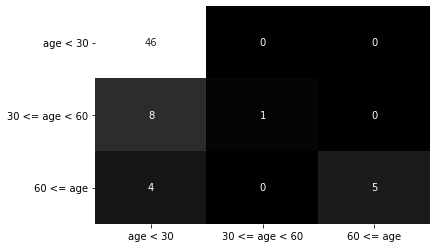

In [254]:
plt.ylabel('True label')
plt.xlabel('Predicted label')
sns.heatmap(cf_m, annot=True, cmap='gray', xticklabels=classes, yticklabels=classes,
           cbar=False)

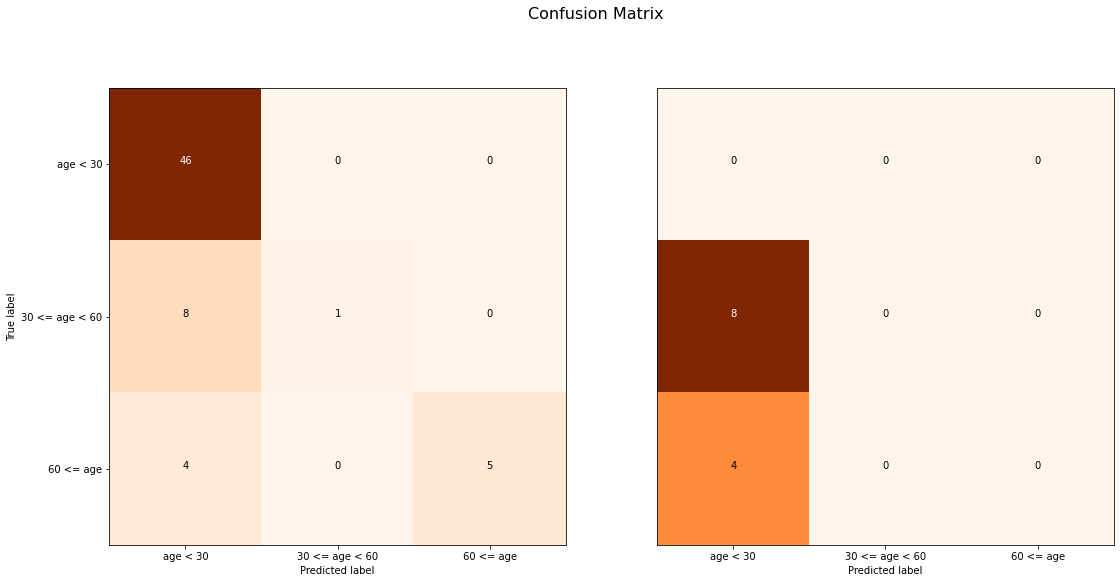

In [367]:
import copy
import itertools

cm = confusion_matrix(labels, outputs)

def plot_confusion_matrix(cm, cmap=plt.cm.Oranges):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
    fig.suptitle('Confusion Matrix', fontsize=16)
    
    axes[0].imshow(cm, interpolation='nearest', cmap=cmap)
    
    axes[0].set_xticks(range(len(classes)))
    axes[0].set_yticks(range(len(classes)))
    axes[0].set_xticklabels(classes)
    axes[0].set_yticklabels(classes)
    axes[0].set_ylabel('True label')
    axes[0].set_xlabel('Predicted label')
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axes[0].text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    np.fill_diagonal(cm, 0)
    axes[1].imshow(cm, interpolation='nearest', cmap=cmap)
    
    axes[1].set_xticks(range(len(classes)))
    axes[1].set_xticklabels(classes)
    axes[1].set_yticks([])
    axes[1].set_xlabel('Predicted label')
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axes[1].text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
plot_confusion_matrix(cm)

## Plot Images

In [354]:
MEAN = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
STD = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)

images = np.clip((images * STD) + MEAN, 0, 1)
images = images.transpose(0, 2, 3, 1)
images.shape

(64, 224, 224, 3)

In [360]:
images10 = images[(labels == 1) & (outputs == 0)]
# images10 = images[()]

In [361]:
def plot_peoples(instances, images_per_row=10, **options):
    size=224
    image_per_row = min(len(instances), images_per_row)
    images = [instance for instance in instances]    
    n_rows = (len(instances) - 1) // image_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty, 3)))

    for row in range(n_rows):
        rimages = images[row * image_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
        
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, **options)
    plt.axis("off")

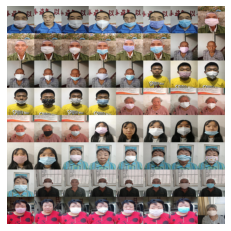

In [362]:
plot_peoples(images, images_per_row=8)

In [364]:
images00 = images[(labels == 0) & (outputs == 0)]
images01 = images[(labels == 0) & (outputs == 1)]
images02 = images[(labels == 0) & (outputs == 2)]
images10 = images[(labels == 1) & (outputs == 0)]
images11 = images[(labels == 1) & (outputs == 1)]
images12 = images[(labels == 1) & (outputs == 2)]
images20 = images[(labels == 2) & (outputs == 0)]
images21 = images[(labels == 2) & (outputs == 1)]
images22 = images[(labels == 2) & (outputs == 2)]

In [ ]:
plt.figure(figsize=(8,8))
try:
plt.subplot(331); plot_peoples(images00[:4], images_per_row=2)
plt.subplot(332); plot_peoples(images01[:4], images_per_row=2)
plt.subplot(333); plot_peoples(images02[:4], images_per_row=2)
plt.subplot(334); plot_peoples(images10[:4], images_per_row=2)
plt.subplot(335); plot_peoples(images11[:4], images_per_row=2)
plt.subplot(336); plot_peoples(images12[:4], images_per_row=2)
plt.subplot(337); plot_peoples(images20[:4], images_per_row=2)
plt.subplot(338); plot_peoples(images21[:4], images_per_row=2)
plt.subplot(339); plot_peoples(images22[:4], images_per_row=2)

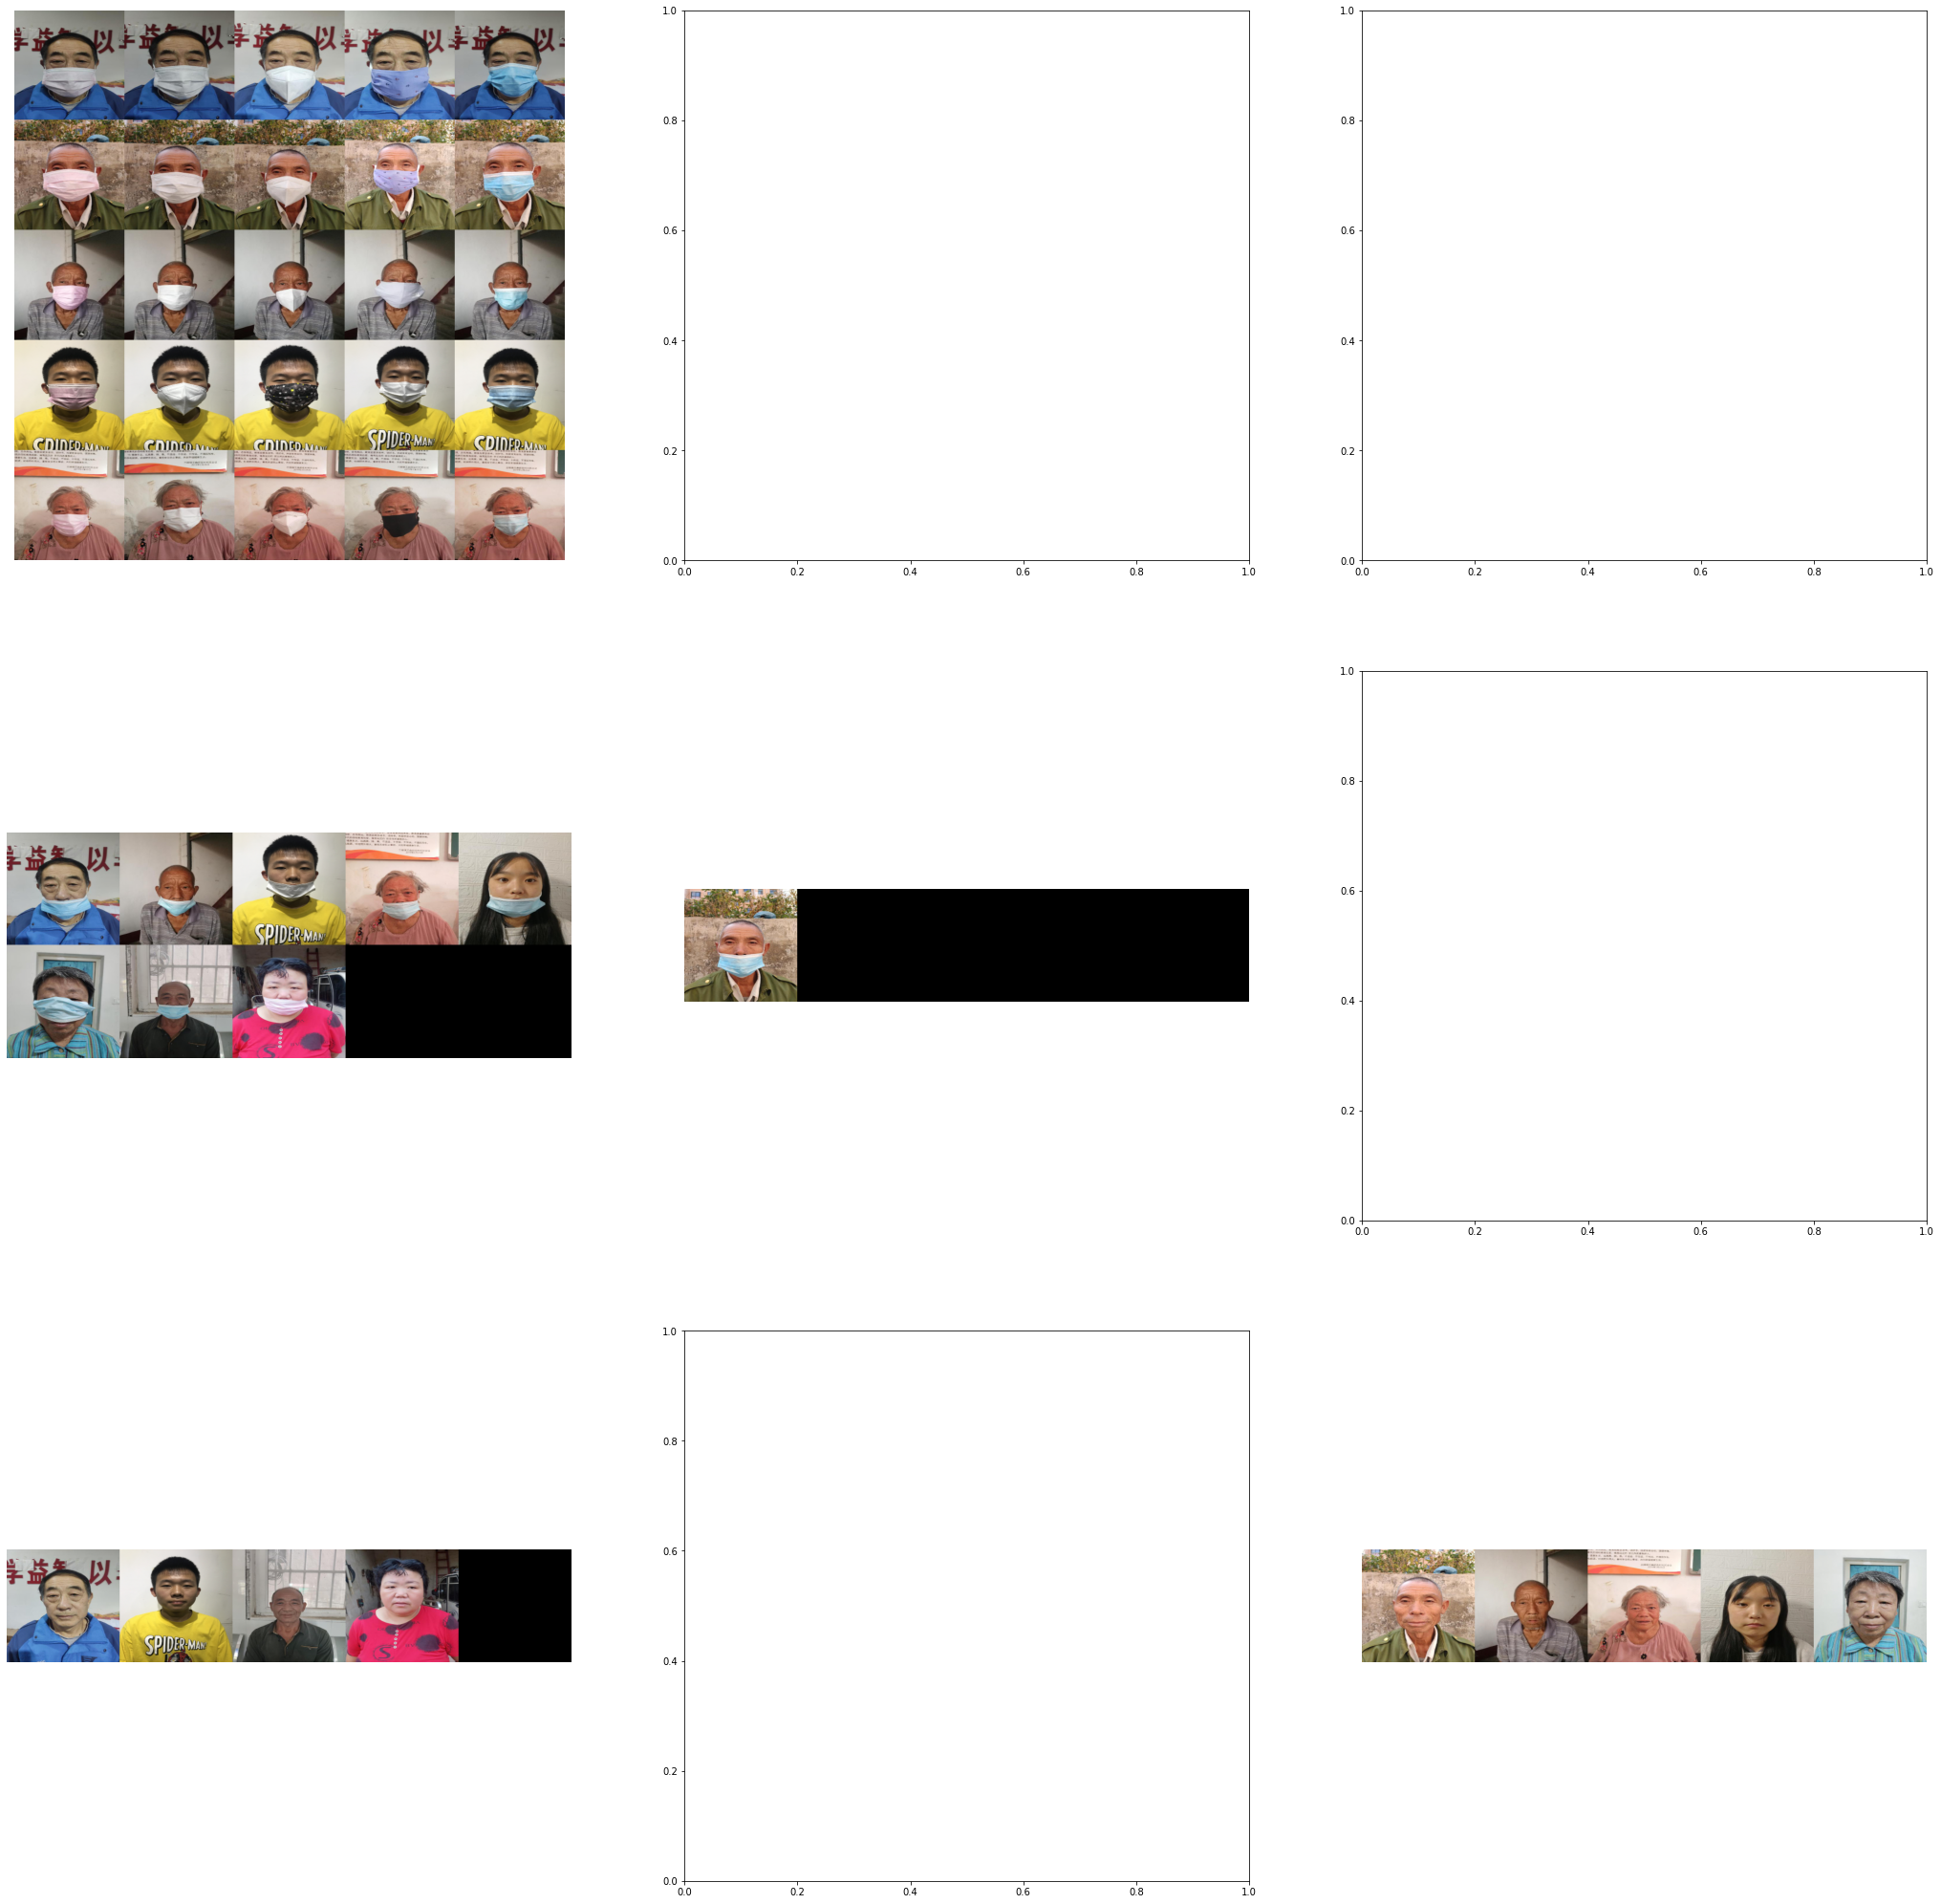

In [376]:
from itertools import product

plt.figure(figsize=(36, 36))

for idx, (label_idx, pred_idx) in enumerate(product(range(3), range(3))):
    conf_images = images[(labels == label_idx) & (outputs == pred_idx)]
    plt.subplot(3, 3, idx + 1)
    try:
        plot_peoples(conf_images[:25], images_per_row=5)
    except:
        pass